# Wielowymiarowe prognozowanie szeregów czasowych za pomocą sieci transformers

Celem projektu było opracowanie sieci typu transformers do modelowania i predykcji wielowymiarowych szeregów czasowych w oparciu o zestaw danych COVID-19 w Polsce (http://bit.ly/covid19-poland)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Dense,
    Input,
    Concatenate,
    GlobalAveragePooling1D,
    Dropout,
    LayerNormalization,
    Conv1D
)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, mean_absolute_percentage_error

# Load data

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/data.csv'
# data_path = '/content/data.csv'
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.shape

(738, 9)

Parametry wybrane po wstępnym przeanalizowaniu zestawu danych

In [ ]:
df.head()

,date,tests,new_deaths,new_recoveries,active_cases,people_hospitalised,occupied_ventilators,quarantined_people,new_cases
0,2020-03-03,0,0,0,0,68,0,316,0
1,2020-03-04,25,0,0,1,65,0,349,1
2,2020-03-05,92,0,0,1,92,0,490,0
3,2020-03-06,179,0,0,5,128,0,1299,4
4,2020-03-07,0,0,0,6,146,0,1548,1


In [ ]:
df.tail()

,date,tests,new_deaths,new_recoveries,active_cases,people_hospitalised,occupied_ventilators,quarantined_people,new_cases
733,2022-03-06,46844,10,4715,508225,9517,620,59973,7697
734,2022-03-07,40897,6,12049,501755,9478,605,79035,5585
735,2022-03-08,85341,217,9990,504700,8936,602,78118,13152
736,2022-03-09,82039,234,9826,509055,8558,557,75926,14415
737,2022-03-10,80543,184,8460,513849,8338,523,72541,13438


# Data visualization

In [ ]:
def draw_plot(x,y,title,x_label,y_label):
  fig, ax = plt.subplots()
  ax.plot(x,y)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(title)
  ax.xaxis.set_major_locator(mdates.MonthLocator()) # The main markers on the x-axis will represent the months.
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Dates will be displayed in year-month format, for example 2022-01.
  plt.xticks(rotation=45)
  plt.show()

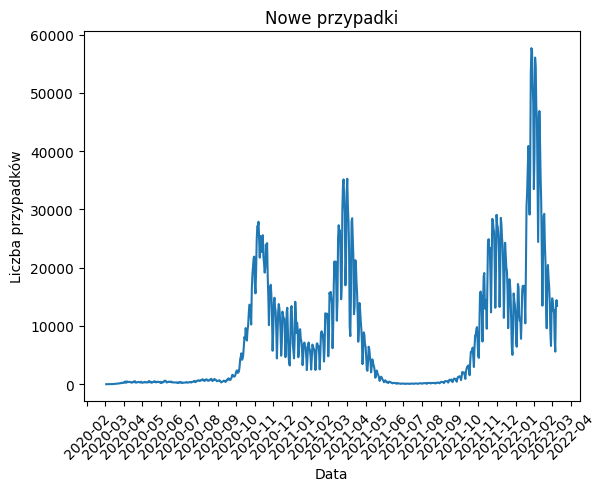

In [ ]:
draw_plot(x=df['date'], y=df['new_cases'],title='Nowe przypadki',x_label='Data',y_label='Liczba przypadków')

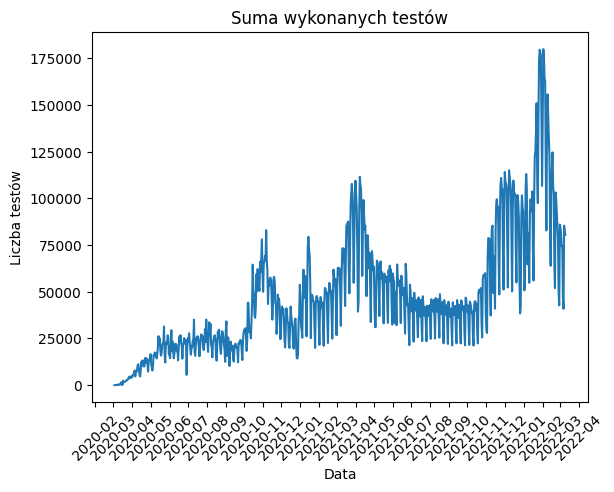

In [ ]:
draw_plot(x=df['date'], y=df['tests'],title='Suma wykonanych testów',x_label='Data',y_label='Liczba testów')

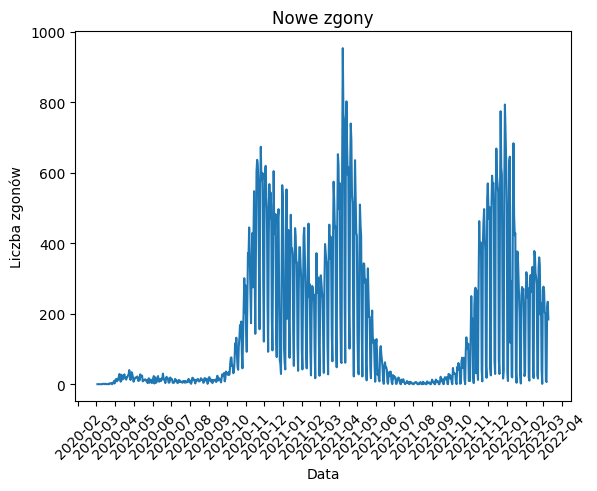

In [ ]:
draw_plot(x=df['date'], y=df['new_deaths'],title='Nowe zgony',x_label='Data',y_label='Liczba zgonów')

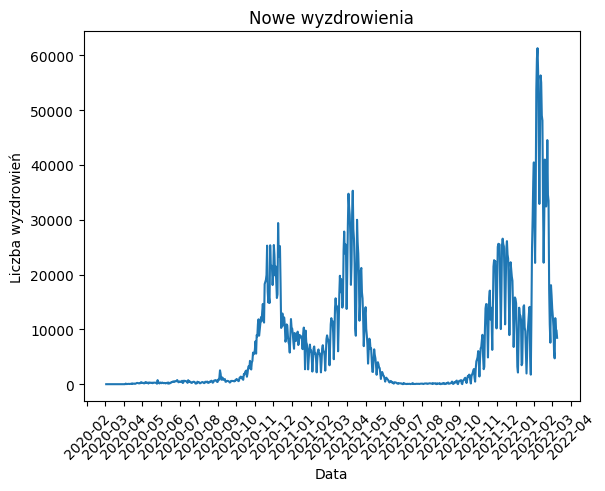

In [ ]:
draw_plot(x=df['date'], y=df['new_recoveries'],title='Nowe wyzdrowienia',x_label='Data',y_label='Liczba wyzdrowień')

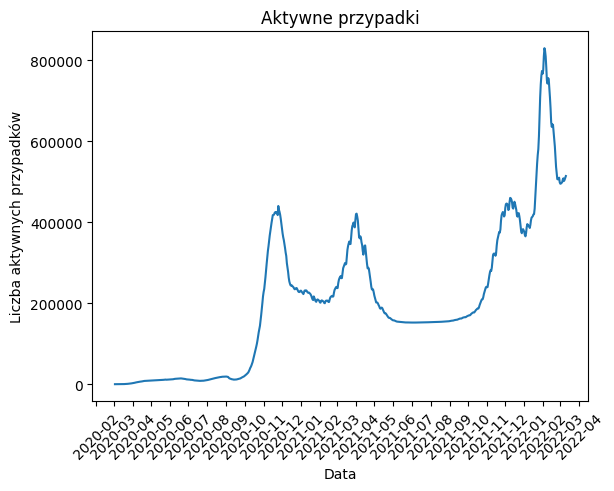

In [ ]:
draw_plot(x=df['date'], y=df['active_cases'],title='Aktywne przypadki',x_label='Data',y_label='Liczba aktywnych przypadków')

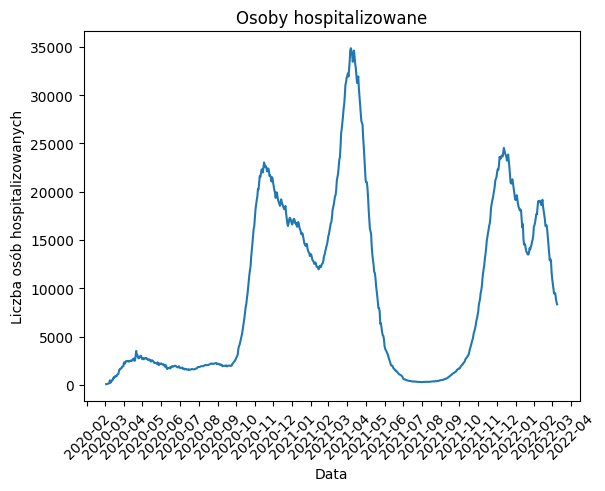

In [ ]:
draw_plot(x=df['date'], y=df['people_hospitalised'],title='Osoby hospitalizowane',x_label='Data',y_label='Liczba osób hospitalizowanych')

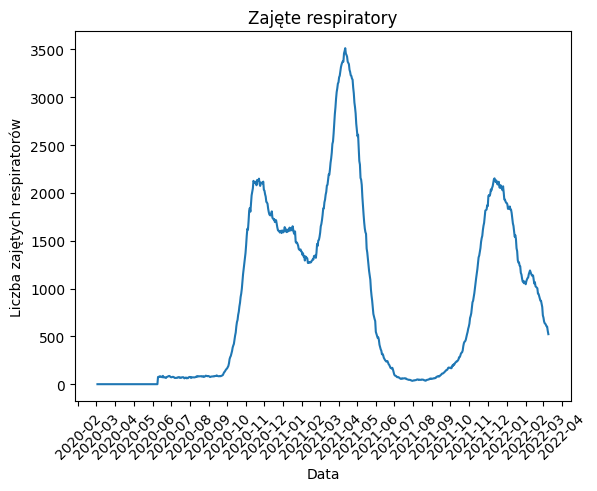

In [ ]:
draw_plot(x=df['date'], y=df['occupied_ventilators'],title='Zajęte respiratory',x_label='Data',y_label='Liczba zajętych respiratorów')

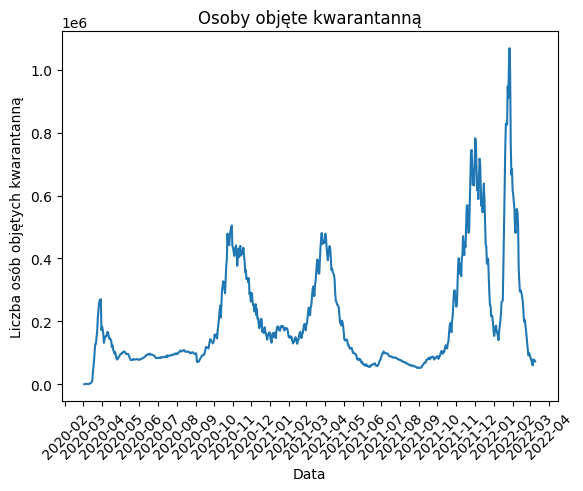

In [ ]:
draw_plot(x=df['date'], y=df['quarantined_people'],title='Osoby objęte kwarantanną',x_label='Data',y_label='Liczba osób objętych kwarantanną')

# Prepare data

In [ ]:
df = df.drop(columns=['date'])

Ostateczne parametry wybrane po analizie wykresów.

In [ ]:
df = df.drop(columns=['new_deaths', 'people_hospitalised', 'occupied_ventilators', 'quarantined_people'])
columns = df.columns
columns

Index(['tests', 'new_recoveries', 'active_cases', 'new_cases'], dtype='object')

W kolumnie ‘tests’ zawierającej informacje o sumie wykonanych testów wartości zerowe zostały zastąpione wartościami z poprzedniego wiersza (metoda backfill) w tej samej kolumnie. Zamiana wartości zerowych na wartości z poprzedniego wiersza może być stosowana w celu uzupełnienia brakujących danych na podstawie dostępnych informacji.

In [ ]:
df['tests'] = df['tests'].replace(to_replace=0, method='bfill')

Dane zostały przeskalowane za pomocą Min-Max Scalera. Min-Max Scaler przekształca wartości cech w zakresie od 0 do 1. Jego działanie polega na odejmowaniu najmniejszej wartości cechy i dzieleniu przez różnicę pomiędzy największą i najmniejszą wartością cechy.

In [ ]:
scaler = MinMaxScaler()
df[columns] = scaler.fit_transform(df[columns])
df.head()

,tests,new_recoveries,active_cases,new_cases
0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.000001,0.000017
2,0.000373,0.0,0.000001,0.000000
3,0.000857,0.0,0.000006,0.000069
4,0.001524,0.0,0.000007,0.000017


# Create model

Time2Vector to warstwa embeddingowa mająca na celu zakodowanie informacji o czasie w sekwencyjnych danych, poprzez reprezentację czasu w postaci wektora. Otrzymana reprezentacja czasu skonstruowana jest w taki sposób aby wyszukiwać zarówno wzorce nieokresowe (liniowe) oraz okresowe (przy pomocy funkcji sinusoidalnej).

In [ ]:
class Time2Vector(Layer):
  '''Embedding Layer representing time as a vector'''
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len # length of a time sequence in each input

  def build(self, input_shape):
    '''Initializes weights for periodic and non-periodic features'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculates periodic and non-periodic features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # non-periodic feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic) # periodic feature
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension
    return tf.concat([time_linear, time_periodic], axis=-1)

  def get_config(self):
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config


Warstwa SingleAttention korzysta z mechanizmu self-attention, pozwalając modelowi skupić się na istotnych częściach danych. Na wejściu przyjmuje 3 macierze: query, key oraz value.

query - reprezentuje docelowy szereg czasowy, którego model ma użyć do prognozy

key - reprezentuje dane historyczne w stosunku do query, pozwala modelowi na wykrycie zależności w danych historycznych

value - reprezentuje dodatkową informację, która może posłużyć do prognozy

Model wylicza podobieństwo pomiędzy query i key (iloczyn skalarny), a następnie skaluje i normalizuje wynik, w ten sposób wyznaczając macierz wag uwagi. Korzystając z tej macierzy oraz macierzy value, wyliczana jest ich suma ważona (attn_out) która odzwierciedla inne części sekwencji wejściowej z uwzględnieniem ich przydatności.

In [ ]:
class SingleAttention(Layer):
  '''Single attention layer'''
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    ''' Initialized dense networks for each of inputs'''
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs):
    ''' Calculated attention output '''
    q = self.query(inputs[0]) # represents positions of interest in the sequence
    k = self.key(inputs[1]) # represents information about different positions

    attn_weights = tf.matmul(q, k, transpose_b=True) # dot product measures similarity between query and key
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights) # scaling the dot product (to stabilize gradients)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1) # normalize attention weights to 1 using softmax

    v = self.value(inputs[2]) # represents features
    attn_out = tf.matmul(attn_weights, v) # emphasizes the value vectors that are most relevant to each query position
    return attn_out # return relevant information form the value vector

Warstwa MultiAttention ma na celu połączenie wyników z określonej liczby warstw SingleAttention oraz poddanie wyniku nieliniowej transformacji za pomocą sieci gęstej.

In [ ]:
class MultiAttention(Layer):
  '''Multi attention layer'''
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    ''' Creates n_heads SingleAttention layers and a Dense layer'''
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    ''' Concatenates and lineary transforms output from each SingleAttention layer'''
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

Warstwa TransformerEncoder opakowuje warstwy MultiAttention, dodając warstwy Dropout, LayerNormalization, a także sieć jednokierunkową, w tym przypadku składającą się z warstw konwolucyjnych (Conv1D).

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    # self-attention part
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    # feed forward part
    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs):
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self):
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

seq_len = 28
num_features = 4

Ostatecznie model składa się z 3 warstw TransformerEncoder, a także dodatkowych warstw gromadzących dane, Dropout, i sieci gęstych.

In [ ]:
def create_model():
    '''Initialize time embedding and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, num_features))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

def calculate_index_of_agreement(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    index_of_agreement = 1 - (numerator / denominator)
    return index_of_agreement

# Define helper functions for evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    index_of_agreement = calculate_index_of_agreement(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, index_of_agreement, mape

def print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores):
    print('---------------------------')
    print('Average MSE:', np.mean(mse_scores))
    print('Average MAE:', np.mean(mae_scores))
    print('Average R^2:', np.mean(r2_scores))
    print(f"Mean Index of Agreement: {np.mean(index_of_agreement_scores)}")
    print(f"MAPE: {np.mean(mape_scores)}")
    print('---------------------------')

# Model assessment

n_splits - liczba podziałów w każdej metodzie

batch_size - wielkość paczki danych

num_epochs - ilość epok treningu

In [ ]:
n_splits = 4

batch_size = 16
num_epochs = 50

### Model assessment using KFold

Metoda k-fold charakteryzuje się podziałem zbioru danych na k równych części (foldów) i iteracyjnym trenowaniem i testowaniem modelu, używając różnych kombinacji foldów jako zestawu treningowego i testowego. Dane treningowe są przekształcane do postaci X_train (wejście) i y_train (wartość docelowa).
Dane testowe są przekształcane do postaci X_test (wejście) i y_test (wartość docelowa).

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []
index_of_agreement_scores = []
mape_scores = []

kfold = KFold(n_splits=n_splits)

for train_index, test_index in kfold.split(df):

    # Split data into train and test
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values

    # Arrange train data into X_train and y_train
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i-seq_len:i])
        y_train.append(train_data[:, num_features-1][i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Arrange test data into X_test and y_test
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, num_features-1][i])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and train model
    model = create_model()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    index_of_agreement_scores.append(index_of_agreement)
    mape_scores.append(mape)

    print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}, Index of Agreement: {index_of_agreement}, Mean Absolute Percentage Error: {mape} ")

# Print evaluation results for the current split method
print("Split Method: KFold")
print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores)

5/5 [==============================] - 8s 203ms/step
MSE: 0.0005964504686736187, MAE: 0.016564312498601227, R^2: -69.46495503403904, Index of Agreement: 0.11286226944059186, Mean Absolute Percentage Error: 2.727848211681467 
5/5 [==============================] - 6s 127ms/step
MSE: 0.003172726187862796, MAE: 0.04607952183962474, R^2: 0.7442336691141762, Index of Agreement: 0.41124654057230836, Mean Absolute Percentage Error: 0.3014231442432841 
5/5 [==============================] - 6s 121ms/step
MSE: 0.0015546422468116004, MAE: 0.02833987450774349, R^2: 0.83836972197923, Index of Agreement: 0.3009702192164977, Mean Absolute Percentage Error: 5.837940080374225 
5/5 [==============================] - 10s 128ms/step
MSE: 0.019071091204781652, MAE: 0.09152796838890084, R^2: 0.612168034352762, Index of Agreement: 0.3891838998174971, Mean Absolute Percentage Error: 0.31572831112221805 
Split Method: KFold
---------------------------
Average MSE: 0.006098727527032417
Average MAE: 0.045627919

### Model assessment using TimeSeriesSplit

Metoda TimeSeriesSplit charakteryzuje się podziałem szeregów czasowych na sekwencję punktów danych, gdzie jedna część jest używana do treningu, a kolejna część do walidacji, biorąc pod uwagę chronologię danych, co pozwala na ocenę modelu na przyszłych danych.

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []
index_of_agreement_scores = []
mape_scores = []

tss = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tss.split(df):

    # Split data into train and test
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values

    # Arrange train data into X_train and y_train
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i-seq_len:i])
        y_train.append(train_data[:, num_features-1][i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Arrange test data into X_test and y_test
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, num_features-1][i])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and train model
    model = create_model()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    index_of_agreement_scores.append(index_of_agreement)
    mape_scores.append(mape)

    print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}, Index of Agreement: {index_of_agreement}, Mean Absolute Percentage Error: {mape} ")

# Print evaluation results for the current split method
print("Split Method: TimeSeriesSplit")
print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores)

4/4 [==============================] - 7s 124ms/step
MSE: 0.04697004328345043, MAE: 0.16176430324515978, R^2: -1.2571550188367753, Index of Agreement: 0.45984649153628554, Mean Absolute Percentage Error: 0.8136521165897257 
4/4 [==============================] - 5s 113ms/step
MSE: 0.04433916333423548, MAE: 0.18443577480283135, R^2: -0.8794139729123682, Index of Agreement: 0.40054480634878287, Mean Absolute Percentage Error: 2.0009107531074775 
4/4 [==============================] - 7s 124ms/step
MSE: 0.0016634976365358317, MAE: 0.038471940562727173, R^2: -16.17035873439778, Index of Agreement: 0.20955384276136224, Mean Absolute Percentage Error: 11.134676108468314 
4/4 [==============================] - 7s 128ms/step
MSE: 0.018966858438481372, MAE: 0.09551282319162757, R^2: 0.5814409009101195, Index of Agreement: 0.4074830845291766, Mean Absolute Percentage Error: 0.24124628563091285 
Split Method: TimeSeriesSplit
---------------------------
Average MSE: 0.027984890673175777
Average MA

### Model assessment using BlockingTimeSeriesSplit

n_splits - określa liczbę podziałów (bloków)

margin - określa margines pomiędzy blokami


Metoda split wykonuje właściwy podział danych. Przyjmuje argumenty X, y i groups, ale w tym przypadku nie są one wykorzystywane. Dla każdego podziału (bloku) iteruje po indeksach danych i zwraca pary indeksów, które stanowią część treningową (pierwszy blok) i część treningową (drugi blok) z uwzględnieniem marginesu.

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, margin=0):
        self.n_splits = n_splits
        self.margin = margin

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + self.margin: stop]

Metoda BlockingTimeSeriesSplit jest podobna do TimeSeriesSplit, ale dodatkowo blokuje pewną część danych jako tzw. blok trenujący, który jest używany do oceny ostatecznej wydajności modelu.

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []
index_of_agreement_scores = []
mape_scores = []

btss = BlockingTimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in btss.split(df):

    # Split data into train and test
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values

    # Arrange train data into X_train and y_train
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
        X_train.append(train_data[i-seq_len:i])
        y_train.append(train_data[:, num_features-1][i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Arrange test data into X_test and y_test
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data)):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, num_features-1][i])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Build and train model
    model = create_model()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    index_of_agreement_scores.append(index_of_agreement)
    mape_scores.append(mape)

    print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}, Index of Agreement: {index_of_agreement}, Mean Absolute Percentage Error: {mape} ")

# Print evaluation results for the current split method
print("Split Method: TimeSeriesSplit")
print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores)

1/1 [==============================] - 7s 7s/step
MSE: 4.013922085734651e-05, MAE: 0.005988197756754153, R^2: -8.377741347338086, Index of Agreement: 0.35598004300823427, Mean Absolute Percentage Error: 0.4846651456334859 


1/1 [==============================] - 7s 7s/step
MSE: 0.0022953760569024745, MAE: 0.042779500552834936, R^2: 0.3787000112430927, Index of Agreement: 0.4131341435690179, Mean Absolute Percentage Error: 0.2204717824350463 


1/1 [==============================] - 6s 6s/step
MSE: 2.259048022045364e-06, MAE: 0.0011443059364159565, R^2: -0.23255054600059566, Index of Agreement: 0.38099651903709497, Mean Absolute Percentage Error: 0.3042317720107326 
1/1 [==============================] - 6s 6s/step
MSE: 0.004301025678878745, MAE: 0.043140627956053654, R^2: -0.32727318579685205, Index of Agreement: 0.44964399294884605, Mean Absolute Percentage Error: 0.35988001729680935 
Split Method: TimeSeriesSplit
---------------------------
Average MSE: 0.0016597000011651527
Average MAE: 0.023263158050514675
Average R^2: -2.1397162669731102
Mean Index of Agreement: 0.3999386746407983
MAPE: 0.34231217934401853
---------------------------


# Final model training

Do ostatecznego treningu modelu dane podzielono w następujący
sposób: dane treningowe (70%), dane walidacyjne (10%), dane testowe (20%).

In [ ]:
#Split df into df_train and df_test

split_index_1 = sorted(df.index.values)[-int(0.3*len(df))]
split_index_2 = sorted(df.index.values)[-int(0.2*len(df))]

df_train = df[(df.index < split_index_1)] # 70% of data
df_val = df[(df.index >=split_index_1) & (df.index < split_index_2)] # 10% of data
df_test = df[(df.index >= split_index_2)] # 20% of data

train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (517, 4)
Validation data shape: (74, 4)
Test data shape: (147, 4)


A następnie ułożono w sekwencje X (o długości seq_len=28) i y.

In [ ]:
# Arrange train data into X_train and y_train
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, num_features-1][i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Arrange validation data into X_val and y_val
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
  X_val.append(val_data[i-seq_len:i])
  y_val.append(val_data[:, num_features-1][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Arrange test data into X_test and y_test
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, num_features-1][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(489, 28, 4) (489,)
(46, 28, 4) (46,)
(119, 28, 4) (119,)


In [ ]:
# Train the final model on the entire training set
final_model = create_model()
final_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 28, 4)]      0           []                               
                                                                                                  
 time2_vector_12 (Time2Vector)  (None, 28, 2)        112         ['input_13[0][0]']               
                                                                                                  
 concatenate_12 (Concatenate)   (None, 28, 6)        0           ['input_13[0][0]',               
                                                                  'time2_vector_12[0][0]']        
                                                                                                  
 transformer_encoder_36 (Transf  (None, 28, 6)       86308       ['concatenate_12[0][0]',  

Trening trwał 50 epok, podczas treningu zapisywano najlepszą wersję modelu w oparciu o wartość funkcji straty na danych walidacyjnych.

In [ ]:
batch_size_final = 16
num_epochs_final = 50

callback = tf.keras.callbacks.ModelCheckpoint('model.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True,
                                              verbose=1)

In [ ]:
history = final_model.fit(X_train, y_train, batch_size=batch_size_final,
                          epochs=num_epochs_final, validation_data=(X_val, y_val),
                          callbacks=[callback], verbose=1)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0189 - mae: 0.0977 - mape: 848.3304
Epoch 1: val_loss improved from inf to 0.00242, saving model to model.hdf5
31/31 [==============================] - 61s 434ms/step - loss: 0.0189 - mae: 0.0977 - mape: 848.3304 - val_loss: 0.0024 - val_mae: 0.0479 - val_mape: 536.2645
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0103 - mae: 0.0679 - mape: 426.4276
Epoch 2: val_loss improved from 0.00242 to 0.00018, saving model to model.hdf5
31/31 [==============================] - 6s 207ms/step - loss: 0.0103 - mae: 0.0679 - mape: 426.4276 - val_loss: 1.7512e-04 - val_mae: 0.0118 - val_mape: 138.7722
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0069 - mae: 0.0518 - mape: 235.1404
Epoch 3: val_loss improved from 0.00018 to 0.00017, saving model to model.hdf5
31/31 [==============================] - 9s 279ms/step - loss: 0.0069 - mae: 0.0518 - mape: 235.1404 - val_loss: 1.7163e-04 - 

Wartości funkcji straty na danych treningowych i walidacyjnych na przestrzeni treningu.

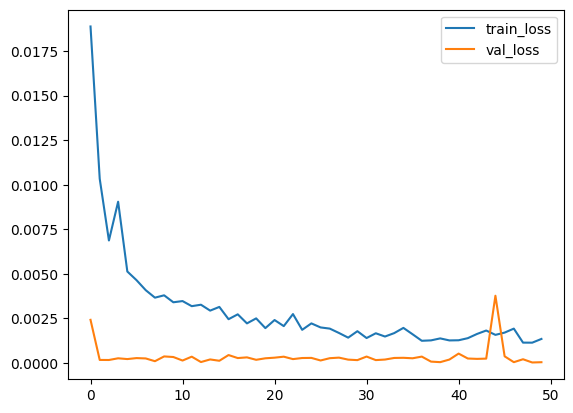

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax = plt.subplot()
line1, = ax.plot(train_loss, label='train_loss')
line2, = ax.plot(val_loss, label='val_loss')
ax.legend(handles=[line1, line2])
plt.show()

Wczytanie najlepszej wersji modelu.

In [ ]:
final_model = tf.keras.models.load_model('/content/model.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Ewaluacja na danych treningowych.

In [ ]:
# Evaluate the final model on the train set
y_pred_train = final_model.predict(X_train)
mse, mae, r2, index_of_agreement, mape = evaluate_model(y_train, y_pred_train)

print('Final Model Evaluation Results (Train Set):')
print_evaluation_results_extended(mse, mae, r2, index_of_agreement, mape)

16/16 [==============================] - 4s 230ms/step
Final Model Evaluation Results (Train Set):
---------------------------
Average MSE: 0.0008339403432611366
Average MAE: 0.016155907724206567
Average R^2: 0.955644013952674
Mean Index of Agreement: 0.3762976617355004
MAPE: 0.3050161655376442
---------------------------


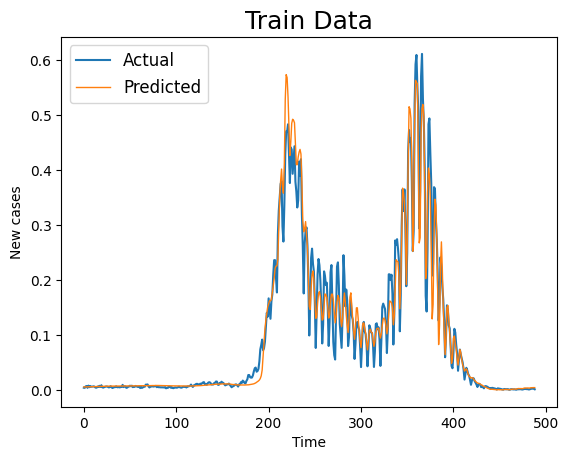

In [ ]:
# Create subplots for results
ax = plt.subplot()

# Plot test data results
ax.plot(y_train.flatten(), label='Actual')
ax.plot(y_pred_train.flatten(), linewidth=1, label='Predicted')
ax.set_title("Train Data", fontsize=18)
ax.set_xlabel('Time')
ax.set_ylabel('New cases')
ax.legend(loc="best", fontsize=12)

# Display the plot
plt.show()

Ewaluacja na danych testowych.

In [ ]:
# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
mse, mae, r2, index_of_agreement, mape = evaluate_model(y_test, y_pred)

print('Final Model Evaluation Results:')
print_evaluation_results_extended(mse, mae, r2, index_of_agreement, mape)

4/4 [==============================] - 0s 115ms/step
Final Model Evaluation Results:
---------------------------
Average MSE: 0.02882426452261324
Average MAE: 0.11396714894893353
Average R^2: 0.3639084601361432
Mean Index of Agreement: 0.38569917725240055
MAPE: 0.26393492300640614
---------------------------


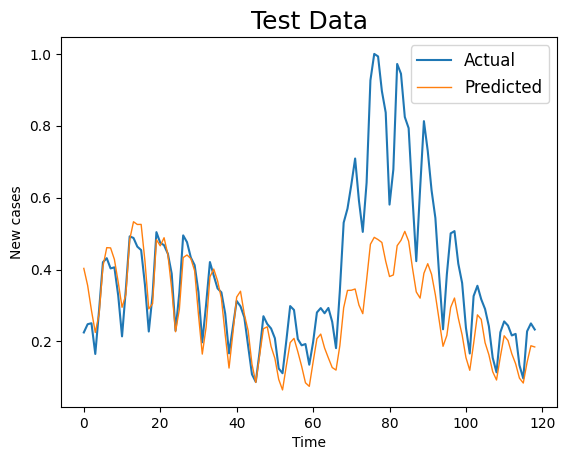

In [ ]:
# Create subplots for results
ax = plt.subplot()

# Plot test data results
ax.plot(y_test.flatten(), label='Actual')
ax.plot(y_pred.flatten(), linewidth=1, label='Predicted')
ax.set_title("Test Data", fontsize=18)
ax.set_xlabel('Time')
ax.set_ylabel('New cases')
ax.legend(loc="best", fontsize=12)

# Display the plot
plt.show()

Uzyskane wyniki są dobre. Model dobrze poradził sobie z przewidzeniem trendów zmian nowych zachorowań. Niestety model nie poradził sobie w przypadku, zaistnienia niespodziewanego ogromnego przyrostu zachorowań.